5.900000000000001e-13


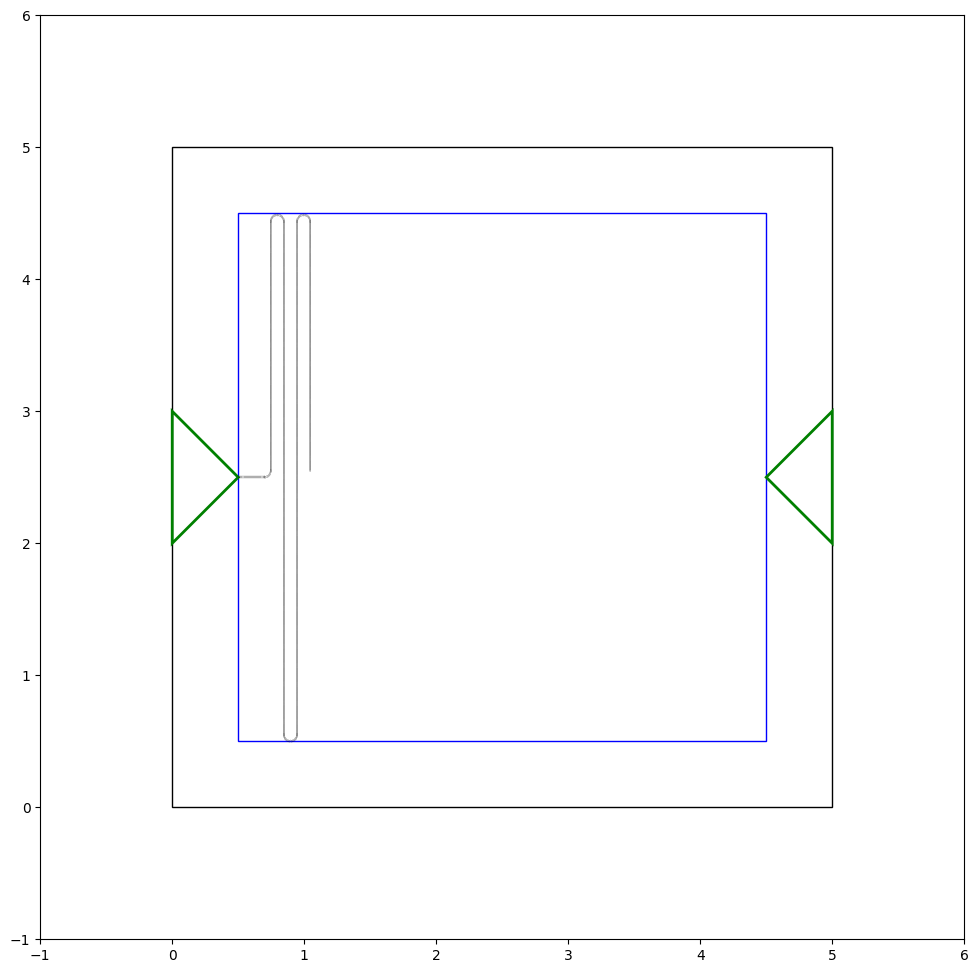

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Constants
e0 = 8.85e-12

class ReverseKerrTWPAGeometry:
    def __init__(self, chip_height, chip_width, margin, launchpads, pad_x, pad_y,
                 chip_separation, line_gap, line_width, relative_permitivity, 
                 device_width, delay_length):
        # Substrate parameters
        self.chip_height = chip_height
        self.chip_width = chip_width
        self.margin = margin

        # Launchpads is a list of coordinates
        self.launchpads = launchpads

        # Ground capacitance parameters
        self.pad_x = pad_x
        self.pad_y = pad_y
        self.chip_separation = chip_separation
        self.relative_permitivity = relative_permitivity

        self.line_gap = line_gap
        self.line_width = line_width
        self.device_width = device_width
        self.turn_radius = line_gap/2
        self.delay_length = delay_length

        # Additional attributes for visualization
        self.fig, self.ax = plt.subplots(figsize=(12,12))

        # Attributes for waveguide layout
        self.num_cells = 0
        self.waveguide_path = []

    def calculate_Cg(self):
        return e0 * self.relative_permitivity * self.pad_x * self.pad_y / self.chip_separation

    def plot_geometry(self):
        # Plot chip boundary
        chip_boundary = plt.Rectangle((0, 0), self.chip_height, self.chip_width, linewidth=1, edgecolor='black',
                                     facecolor='none')
        self.ax.add_patch(chip_boundary)

        # Plot device region
        device_region = plt.Rectangle((self.margin, self.margin),
                                      self.chip_width - 2 * self.margin, self.chip_width - 2 * self.margin,
                                      linewidth=1, edgecolor='blue', facecolor='none')
        self.ax.add_patch(device_region)

        # Plot launchpads
        self.draw_launchpad(self.launchpads[0])
        self.draw_launchpad(self.launchpads[1], flip=True)

        # Plot waveguide
        self.plot_devices()

        # Customize as needed
        self.ax.set_xlim(-1, self.chip_height + 1)
        self.ax.set_ylim(-1, self.chip_width + 1)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

    def draw_launchpad(self, launchpad, flip=False):
        # Customize launchpad shape and size
        if flip:
            launchpad_shape = plt.Polygon([(launchpad[0] - self.margin, launchpad[1]),
                                           (launchpad[0], launchpad[1] + self.margin),
                                           (launchpad[0], launchpad[1] - self.margin)],
                                          edgecolor='green', facecolor='none', linewidth=2)
        else:
            launchpad_shape = plt.Polygon([(launchpad[0], launchpad[1] - self.margin),
                                           (launchpad[0] + self.margin, launchpad[1]),
                                           (launchpad[0], launchpad[1] + self.margin)],
                                          edgecolor='green', facecolor='none', linewidth=2)
        self.ax.add_patch(launchpad_shape)

    def plot_devices(self):

        # Plot the waveguide in a snaking fashion
        waveguide_start = np.array([self.launchpads[0][0] + self.margin, self.launchpads[0][1]])
        waveguide_end = np.array([self.launchpads[1][0] - self.margin, self.launchpads[1][1]])

        N_delay_cells = int(self.delay_length / self.device_width)
        for delay_cell in range(N_delay_cells):
            #left_delay
            x_pos = waveguide_start[0] + self.device_width * delay_cell
            y_pos = waveguide_start[1]
            self.draw_waveguide_unit_cell(self.device_width, x_pos, y_pos)

            # #right delay
            # x_pos = waveguide_end[0] - self.device_width * delay_cell
            # y_pos = waveguide_end[1]
            # self.draw_waveguide_unit_cell(self.device_width, x_pos, y_pos)

        waveguide_start = x_pos, y_pos

        # Qrt curved paths
        N_qrt_curve_cells = int(self.turn_radius * np.pi/2 / self.device_width)
        curved_paths = np.linspace(0, np.pi/2, N_qrt_curve_cells)
        for angle in curved_paths:
            #left
            x_pos = waveguide_start[0] + np.sin(angle) * self.turn_radius
            y_pos = waveguide_start[1] - (np.cos(angle)-1) * self.turn_radius
            self.draw_waveguide_unit_cell(self.device_width, x_pos, y_pos, angle)

            #right
        waveguide_start = x_pos, y_pos

        N_half_lin_cells = int( (self.chip_height/2-self.margin-2*self.turn_radius) / self.device_width)
        # Add linear paths with embedded devices
        for half_lin_cell in range(N_half_lin_cells):
            x_pos = waveguide_start[0]
            y_pos = waveguide_start[1] + self.device_width * half_lin_cell
            self.draw_waveguide_unit_cell(self.device_width, x_pos, y_pos, angle=np.pi/2)

        waveguide_start = x_pos, y_pos

        # Half curved paths
        N_half_curve_cells = int(self.turn_radius * np.pi / self.device_width)
        curved_paths = np.linspace(0, np.pi, N_half_curve_cells)
        for angle in curved_paths:
            x_pos = waveguide_start[0] - (np.cos(angle)-1) * self.turn_radius
            y_pos = waveguide_start[1] + np.sin(angle) * self.turn_radius
            self.draw_waveguide_unit_cell(self.device_width, x_pos, y_pos, np.pi/2 - angle)

        waveguide_start = x_pos, y_pos

        N_lin_cells = int( (self.chip_height-2*self.margin-2*self.turn_radius) / self.device_width)
        # Add linear paths with embedded devices
        for lin_cell in range(N_lin_cells):
            x_pos = waveguide_start[0]
            y_pos = waveguide_start[1] - self.device_width * lin_cell
            self.draw_waveguide_unit_cell(self.device_width, x_pos, y_pos, angle=-np.pi/2)

        waveguide_start = x_pos, y_pos

        # Reverse half curved path
        for angle in curved_paths:
            x_pos = waveguide_start[0] - (np.cos(angle)-1) * self.turn_radius
            y_pos = waveguide_start[1] - np.sin(angle) * self.turn_radius
            self.draw_waveguide_unit_cell(self.device_width, x_pos, y_pos, -np.pi/2 + angle)

        waveguide_start = x_pos, y_pos

        # Add linear paths with embedded devices
        for lin_cell in range(N_lin_cells):
            x_pos = waveguide_start[0]
            y_pos = waveguide_start[1] + self.device_width * lin_cell
            self.draw_waveguide_unit_cell(self.device_width, x_pos, y_pos, angle=np.pi/2)

        waveguide_start = x_pos, y_pos

        for angle in curved_paths:
            x_pos = waveguide_start[0] - (np.cos(angle)-1) * self.turn_radius
            y_pos = waveguide_start[1] + np.sin(angle) * self.turn_radius
            self.draw_waveguide_unit_cell(self.device_width, x_pos, y_pos, np.pi/2 - angle)

        waveguide_start = x_pos, y_pos

        # Add half-length linear path
        for half_lin_cell in range(N_half_lin_cells):
            x_pos = waveguide_start[0]
            y_pos = waveguide_start[1] - self.device_width * half_lin_cell
            self.draw_waveguide_unit_cell(self.device_width, x_pos, y_pos, angle=-np.pi/2)

        waveguide_start = x_pos, y_pos

        # Qrt curve path
        curved_paths = np.linspace(0, np.pi/2, N_qrt_curve_cells)
        for angle in curved_paths:
            #left
            x_pos = waveguide_start[0] + np.sin(angle) * self.turn_radius
            y_pos = waveguide_start[1] - (np.cos(angle)-1) * self.turn_radius
            self.draw_waveguide_unit_cell(self.device_width, x_pos, y_pos, angle)

            #right
        waveguide_start = x_pos, y_pos



    def draw_waveguide_unit_cell(self, length, x_pos, y_pos, angle=0):
        # Draw a unit cell of the waveguide
        unit_cell = plt.Rectangle((x_pos, y_pos - self.line_width / 2), length, self.line_width, angle=angle,
                                  linewidth=0.1, edgecolor='black', facecolor='none')
        self.ax.add_patch(unit_cell)

    def calculate_waveguide_cells(self):
        # Calculate the number of waveguide cells based on device geometry
        available_space = self.chip_height - 2 * self.margin
        N_delay_cells = int(self.delay_length / self.device_width)

        N_line_cells = int((available_space - self.device_width - self.turn_radius) / (self.device_width + self.line_gap)) + 1
        N_curved_cells = N_line_cells
        print(f'Total Cells: {N_delay_cells+N_line_cells+N_curved_cells}')
        return N_delay_cells, N_line_cells, N_curved_cells


# Example usage (units of mm)
geometry = ReverseKerrTWPAGeometry(chip_height=5, chip_width=5, margin=0.5, launchpads=[(0, 2.5), (5, 2.5)],
                                  pad_x=5e-3, pad_y=4e-3, chip_separation=300e-6, line_gap=100e-3, line_width=15e-3,
                                  relative_permitivity=1, device_width=8e-3, delay_length = 2e-1)
print(geometry.calculate_Cg())

geometry.plot_geometry()

5.9026666666666666e-15


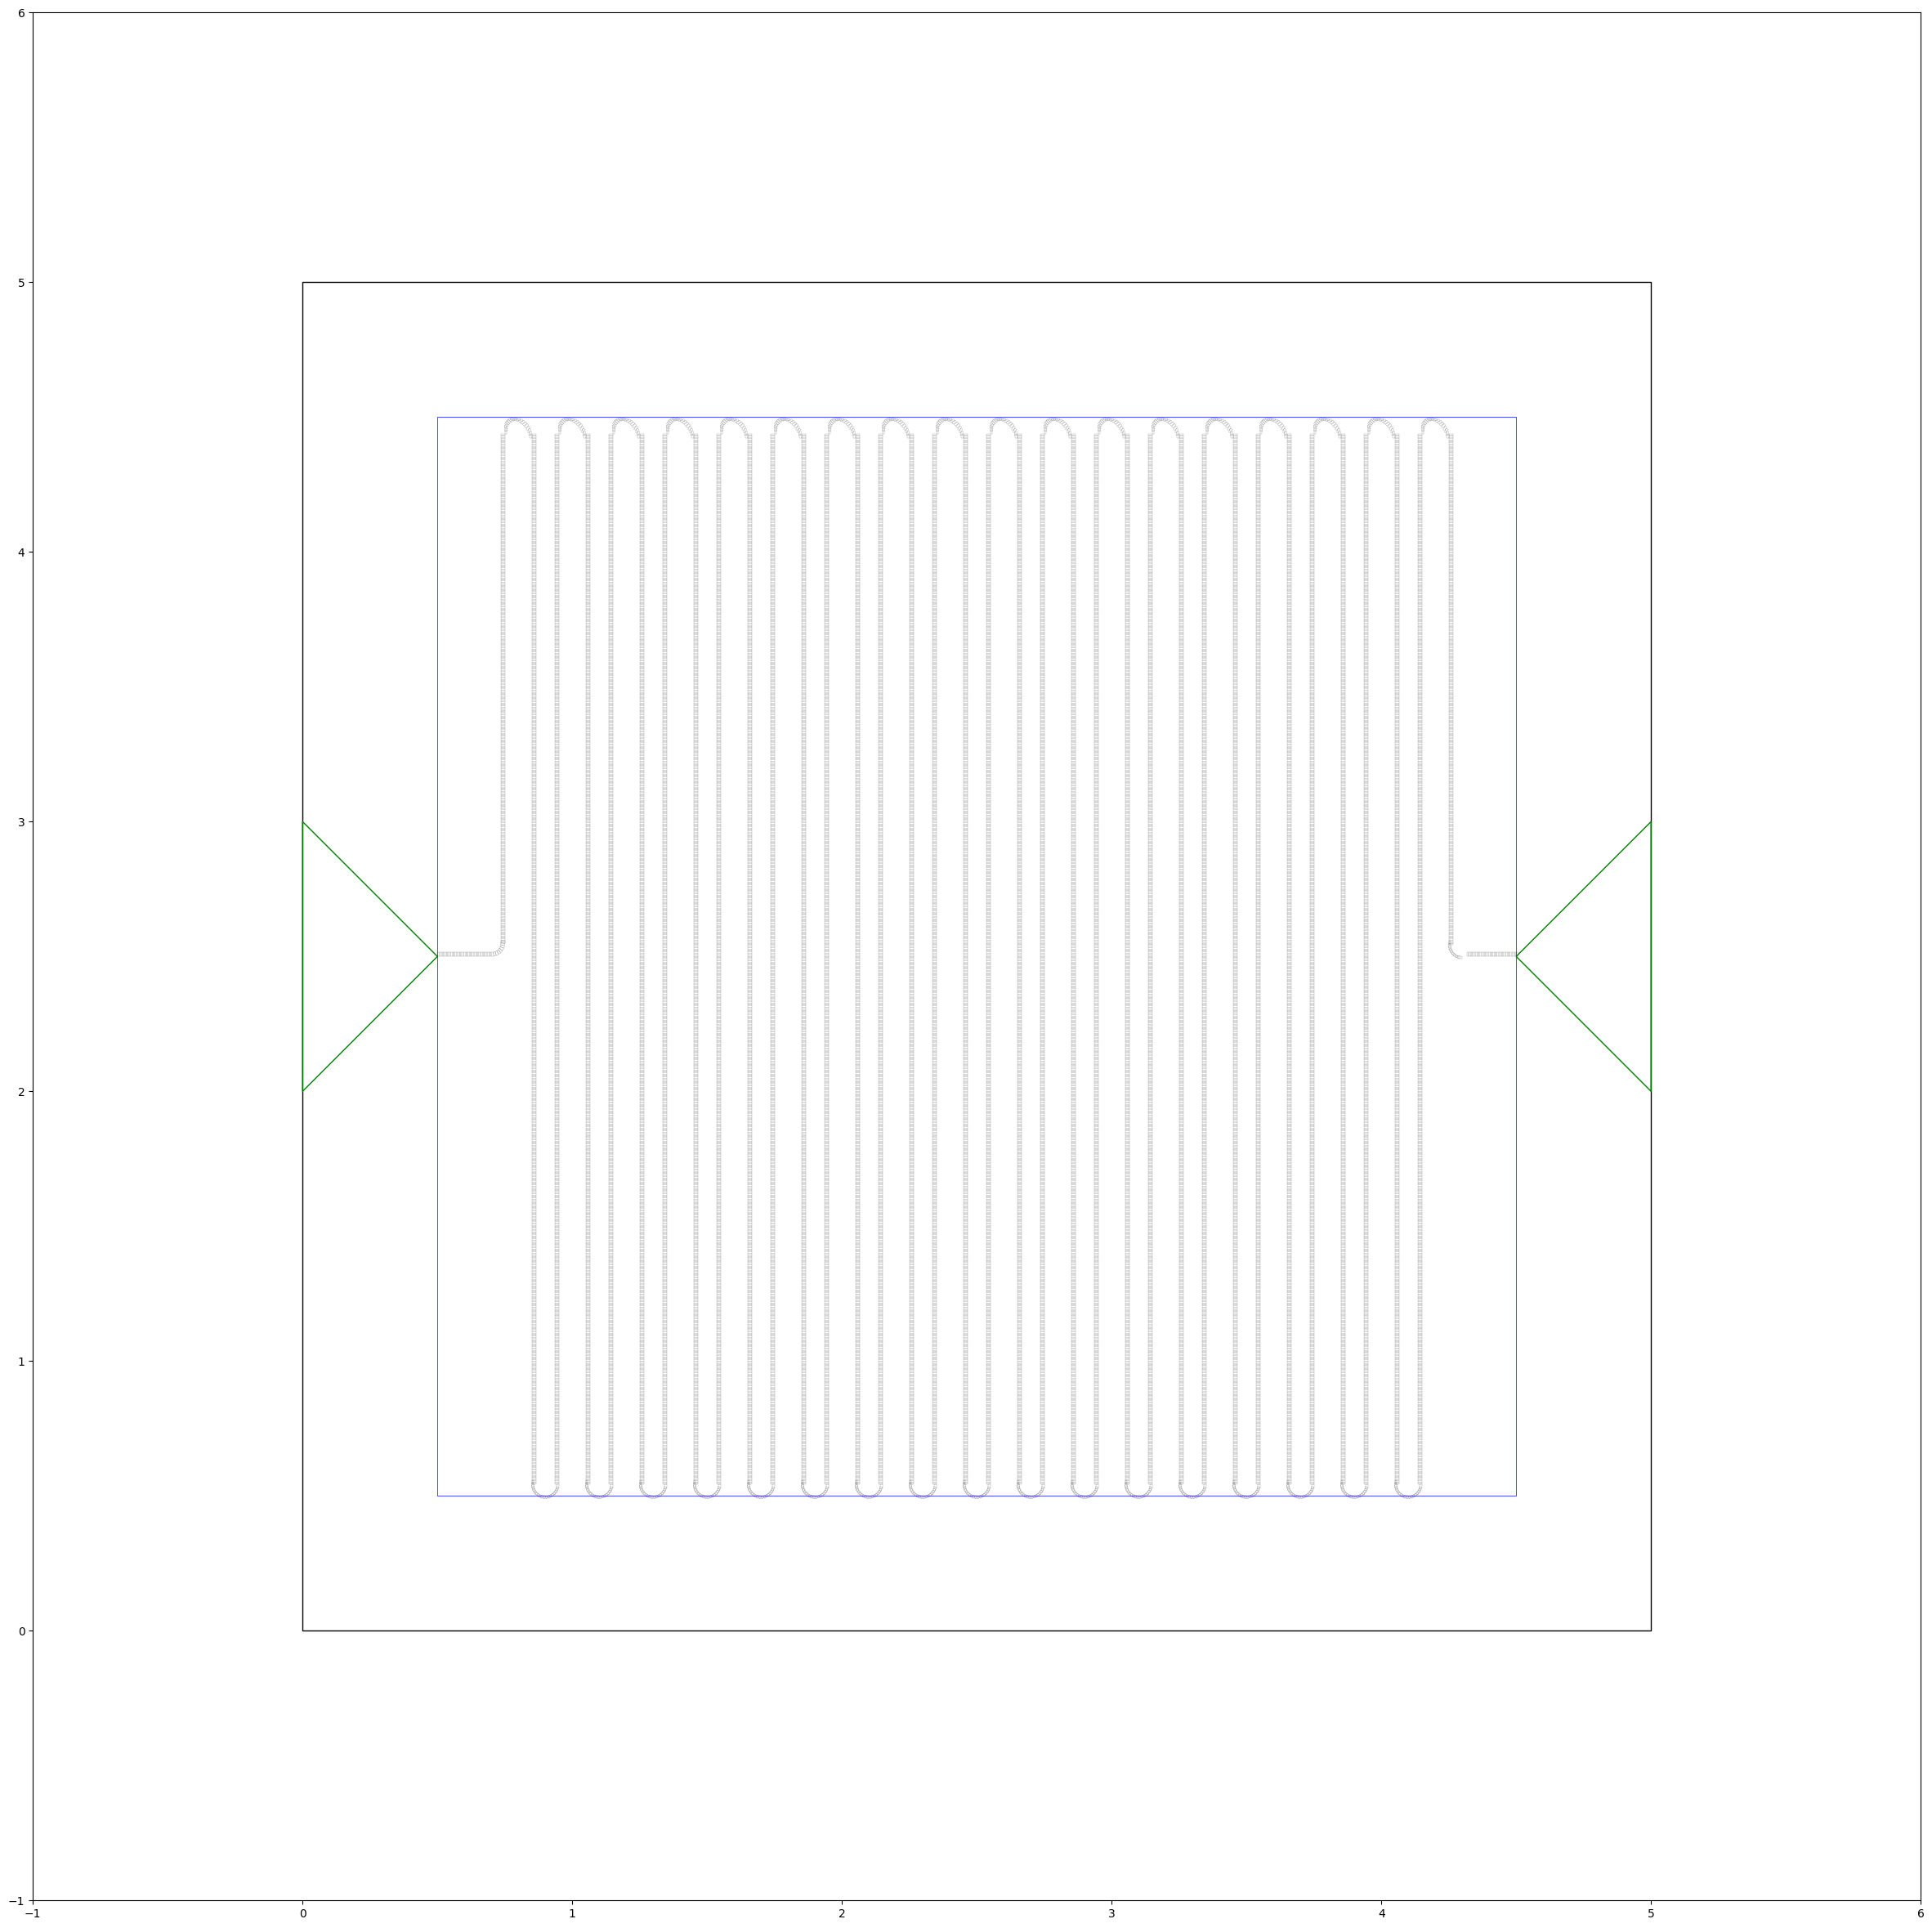

Total Devices: 17763


In [59]:
import matplotlib.pyplot as plt
import numpy as np

# Constants
e0 = 8.854e-12 #F / m

class ReverseKerrTWPAGeometry:
    def __init__(self, chip_height, chip_width, margin, launchpads, pad_x, pad_y,
                 chip_separation, line_gap, line_width, relative_permitivity, 
                 device_width, delay_length):
        # Substrate parameters
        self.chip_height = chip_height
        self.chip_width = chip_width
        self.margin = margin

        # Launchpads is a list of coordinates
        self.launchpads = launchpads

        # Ground capacitance parameters
        self.pad_x = pad_x
        self.pad_y = pad_y
        self.chip_separation = chip_separation
        self.relative_permitivity = relative_permitivity

        self.line_gap = line_gap
        self.line_width = line_width
        self.device_width = device_width
        self.turn_radius = line_gap/2
        self.delay_length = delay_length

        self.total_devices = 0
        # Additional attributes for visualization
        self.fig, self.ax = plt.subplots(figsize=(30,30))

    def calculate_Cg(self):
        return e0 * self.relative_permitivity * 1e-3*self.pad_x * self.pad_y / self.chip_separation

    def plot_geometry(self):
        # Plot chip boundary
        chip_boundary = plt.Rectangle((0, 0), self.chip_height, self.chip_width, linewidth=1, edgecolor='black',
                                     facecolor='none')
        self.ax.add_patch(chip_boundary)

        # Plot device region
        device_region = plt.Rectangle((self.margin, self.margin),
                                      self.chip_width - 2 * self.margin, self.chip_width - 2 * self.margin,
                                      linewidth=0.5, edgecolor='blue', facecolor='none')
        self.ax.add_patch(device_region)

        # Plot launchpads
        self.draw_launchpad(self.launchpads[0])
        self.draw_launchpad(self.launchpads[1], flip=True)

        # Plot waveguide
        self.plot_devices()

        # Customize as needed
        self.ax.set_xlim(-1, self.chip_height + 1)
        self.ax.set_ylim(-1, self.chip_width + 1)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.show()

    def draw_launchpad(self, launchpad, flip=False):
        # Customize launchpad shape and size
        if flip:
            launchpad_shape = plt.Polygon([(launchpad[0] - self.margin, launchpad[1]),
                                           (launchpad[0], launchpad[1] + self.margin),
                                           (launchpad[0], launchpad[1] - self.margin)],
                                          edgecolor='green', facecolor='none', linewidth=1)
        else:
            launchpad_shape = plt.Polygon([(launchpad[0], launchpad[1] - self.margin),
                                           (launchpad[0] + self.margin, launchpad[1]),
                                           (launchpad[0], launchpad[1] + self.margin)],
                                          edgecolor='green', facecolor='none', linewidth=1)
        self.ax.add_patch(launchpad_shape)

    def plot_devices(self):
        # Plot the waveguide in a snaking fashion
        waveguide_start = np.array([self.launchpads[0][0] + self.margin, self.launchpads[0][1]])
        waveguide_end = np.array([self.launchpads[1][0] - self.margin, self.launchpads[1][1]])

        N_delay_cells_left = int(self.delay_length / self.device_width)
        for delay_cell in range(N_delay_cells_left):
            #Left Delay
            x_pos = waveguide_start[0] + self.device_width * delay_cell
            y_pos = waveguide_start[1]
            self.draw_waveguide_unit_cell(self.device_width, x_pos, y_pos)

        waveguide_start = x_pos + self.device_width, y_pos

        # Function to add linear and curved paths with embedded devices
        def add_paths(start, paths):
            for path in paths:
                waveguide_start = self.plot_curved_path(start, path[0], reverse=path[1], qrt=path[2])
                start = self.plot_linear_path(waveguide_start, path[3], path[4])

            N_delay_cells_right = int((waveguide_end[0]-start[0]) / self.device_width)
            for delay_cell in range(N_delay_cells_right):
                #Right Delay
                x_pos = waveguide_end[0] - self.device_width * delay_cell
                y_pos = waveguide_end[1]
                self.draw_waveguide_unit_cell(self.device_width, x_pos, y_pos)

        def generate_paths(N):
            paths = [(np.pi/2, False, True, self.chip_height/2-self.margin-2*self.turn_radius-self.device_width, np.pi/2)]

            # Add repeated entries
            for _ in range(N):  # Adjust the range based on the number of repeated entries
               (paths.append((np.pi, True, False, self.chip_height-2*self.margin-2*self.turn_radius, np.pi/2)) if _%2 
                else paths.append((np.pi, False, False, self.chip_height-2*self.margin-2*self.turn_radius, -np.pi/2)))

            # Add unique entries
            paths.append(
                ((np.pi, True, False, self.chip_height/2-self.margin-2*self.turn_radius, np.pi/2) if N%2 
                else (np.pi, False, False, self.chip_height/2-self.margin-2*self.turn_radius, -np.pi/2))
            )
            paths.append(
                (np.pi/2, True, True, 0, np.pi/2)
            )

            return paths

        paths = generate_paths(34)#int((self.chip_width - 2*self.margin - 2*self.delay_length) / (self.line_width+self.line_gap)))
        # Add the paths with embedded devices
        add_paths(waveguide_start, paths)


    def plot_curved_path(self, start, max_angle, reverse=False, qrt=False):
        N_curve_cells = int(self.turn_radius * max_angle / self.device_width)
        curved_paths = np.linspace(0, max_angle, N_curve_cells)

        for angle in curved_paths:
            x_pos, y_pos = self.calculate_position(start, angle, reverse, qrt)
            self.draw_waveguide_unit_cell(self.device_width, x_pos, y_pos, angle)

        return x_pos, y_pos


    def plot_linear_path(self, start, length, angle):
        N_lin_cells = int(length / self.device_width)

        x_pos = start[0]
        y_pos = start[1]

        for lin_cell in range(N_lin_cells):
            x_pos = start[0]
            y_pos = start[1] + self.device_width * (2 * angle / np.pi) * lin_cell
            self.draw_waveguide_unit_cell(self.device_width, x_pos, y_pos, angle)

        return x_pos, y_pos + self.device_width * (2 * angle / np.pi)
    
    def calculate_position(self, start, angle, reverse, qrt):
        if reverse:
            x_pos = start[0] - (np.cos(angle) - 1) * self.turn_radius
            y_pos = start[1] - np.sin(angle) * self.turn_radius
        elif qrt:
            x_pos = start[0] + np.sin(angle) * self.turn_radius
            y_pos = start[1] - (np.cos(angle) - 1) * self.turn_radius
        else:
            x_pos = start[0] - (np.cos(angle) - 1) * self.turn_radius
            y_pos = start[1] + np.sin(angle) * self.turn_radius

        return x_pos, y_pos

    def draw_waveguide_unit_cell(self, length, x_pos, y_pos, angle=0):
        # Draw a unit cell of the waveguide
        unit_cell = plt.Rectangle((x_pos, y_pos), length, self.line_width, angle=np.degrees(angle),
                                  linewidth=0.1, edgecolor='black', facecolor='none')
        self.ax.add_patch(unit_cell)
        self.total_devices += 1


# Example usage (units of mm)
geometry = ReverseKerrTWPAGeometry(chip_height=5, chip_width=5, margin=0.5, launchpads=[(0, 2.5), (5, 2.5)],
                                  pad_x=5e-3, pad_y=4e-3, chip_separation=300e-6, line_gap=100e-3, line_width=15e-3,
                                  relative_permitivity=10, device_width=8e-3, delay_length = 2e-1)
print(geometry.calculate_Cg())
geometry.plot_geometry()
print(f"Total Devices: {geometry.total_devices}")

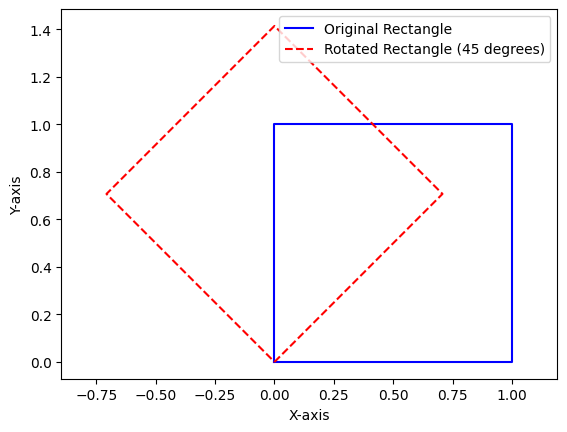

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Coordinates of the rectangle
x = [0, 1, 1, 0, 0]
y = [0, 0, 1, 1, 0]

# Rotation angle in degrees
angle = 45

# Convert angle to radians
angle_rad = np.radians(angle)

# Rotation matrix
rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                            [np.sin(angle_rad), np.cos(angle_rad)]])

# Apply rotation to coordinates
x_rotated, y_rotated = np.dot(rotation_matrix, np.array([x, y]))

# Plot the original rectangle
plt.plot(x, y, label='Original Rectangle', color='blue')

# Plot the rotated rectangle
plt.plot(x_rotated, y_rotated, label=f'Rotated Rectangle ({angle} degrees)', linestyle='--', color='red')

# Set axis limits
plt.xlim(-1, 2)
plt.ylim(-1, 2)
plt.axis('equal')
# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.show()


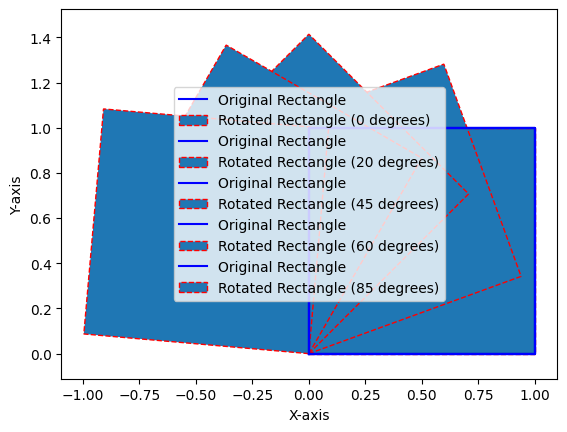

In [37]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

# Coordinates of the rectangle
x = [0, 1, 1, 0, 0]
y = [0, 0, 1, 1, 0]

# Rotation angle in degrees
angles = (0, 20, 45, 60, 85)

for angle in angles:

    # Convert angle to radians
    angle_rad = np.radians(angle)

    # Rotation matrix
    rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                [np.sin(angle_rad), np.cos(angle_rad)]])

    # Apply rotation to coordinates
    x_rotated, y_rotated = np.dot(rotation_matrix, np.array([x, y]))

    # Plot the original rectangle
    plt.plot(x, y, label='Original Rectangle', color='blue')

    # Plot the rotated rectangle using Polygon
    rotated_rectangle = Polygon(np.array([x_rotated, y_rotated]).T, closed=True, edgecolor='red', linestyle='--', label=f'Rotated Rectangle ({angle} degrees)')
    plt.gca().add_patch(rotated_rectangle)

# Set axis limits
plt.xlim(-1, 2)
plt.ylim(-1, 2)

# Set aspect ratio to make the plot square
plt.axis('equal')

# Add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Show the plot
plt.show()
